# CAICT 風機結冰預測 - Data Exploration 


** second key factor **

** 2017/08/08 **   
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

In [6]:
from IPython.display import HTML
HTML('''<script>
presentation = 0;
code_show=true; 
function code_toggle() {
 if (!presentation){
     return;
 }
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

<a id='home'></a>
### Outline
[1. Modules](#load)  
[2. Input Data](#input)  
[3. Single Variable Exploration](#single)    
[4. Multi-Variable Exploration](#multi)
[5. dimension reduction](#dimen)

In [2]:
%matplotlib inline
import sys
import os
import datetime
import pandas as pd
import numpy as np
import lzma
import pickle
import shutil
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.stats as stats
import pylab
from pylab import *
import plastid

from collections import OrderedDict
from PIL import Image

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from IPython.display import HTML

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn import preprocessing

import sklearn
import xgboost as xgb
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "last"

# ‘all’|’last’|’last_expr’|’none’

/Users/jayhsu/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def checkPath(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc: 
            if exc.errno != errno.EEXIST:
                raise

In [4]:
def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled


def load_resample_data(mid, policy=1,  ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    print('load file:',filename)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)

    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_expo_data(mid=15,policy=0):
    non_data_cols = ['label','time','group','timestamp','event']
    data_raw, data_X, _, _ = load_resample_data(mid=mid,policy=policy)
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_raw[col]
    return data_raw,data_scaled


<a id='input'></a>
** Input Data **  
data resample policy
- 15號風機
- remove 無效數據
- 沒有做resampling

In [5]:
_, dat_scaled_M15 = load_expo_data(mid=15,policy=0)
#_, dat_scaled_M15 = load_expo_data(mid=15,policy=4)

#dat_scaled_M15_Complete, _ = add_feature_windspeed(dat_scaled_M15_Complete)
#dat_scaled_M15, _ = add_feature_windspeed(dat_scaled_M15)


load file: data/resample_data_p0_15.csv


In [31]:
xcols=['wind_speed', 'generator_speed', 'wind_direction',
       'wind_direction_mean', 'yaw_position', 'yaw_speed', 'pitch1_angle',
       'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed',
       'pitch3_speed', 'pitch1_moto_tmp', 'pitch2_moto_tmp', 'pitch3_moto_tmp',
       'acc_x', 'acc_y', 'environment_tmp', 'int_tmp', 'pitch1_ng5_tmp',
       'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC', 'pitch2_ng5_DC',
       'pitch3_ng5_DC']

** Exploration **
- Training Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 0 
  - pass data only
- Prediction Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 0  
- model
  - all x
  - xgboost 

  
  

** 1. Power vs Wind_speed Scatter **

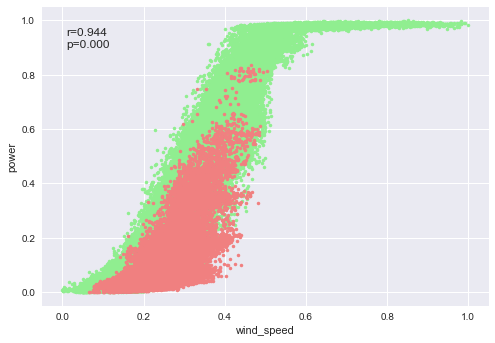

In [6]:
data_pass= dat_scaled_M15[dat_scaled_M15['label']==0]
data_fail= dat_scaled_M15[dat_scaled_M15['label']==1]

x='wind_speed'
y='power'

r, p = pearsonr(data_pass[x],data_pass[y])
raw_clr = 'lightgreen' if r>0.5 else 'darkgray'

data_visual = data_pass[[y, x]]
plt.plot(data_visual[x],data_visual[y],'.', color=raw_clr)

data_visual = data_fail[[y, x]]
plt.plot(data_visual[x],data_visual[y],'.', color='lightcoral')

msg = 'r={corr:.3f}\np={pval:.3f}'.format(corr=r, pval=p)
plt.text(0.01,0.9,msg)
plt.xlabel(x)
plt.ylabel(y)
plt.show(y)

** 2. Predict Power by all X **

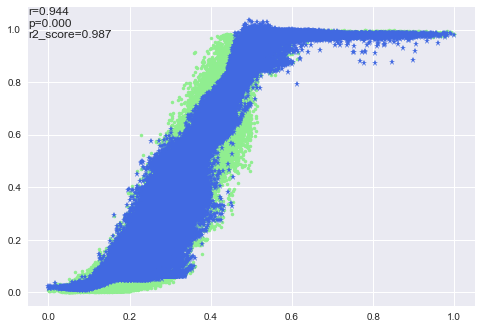

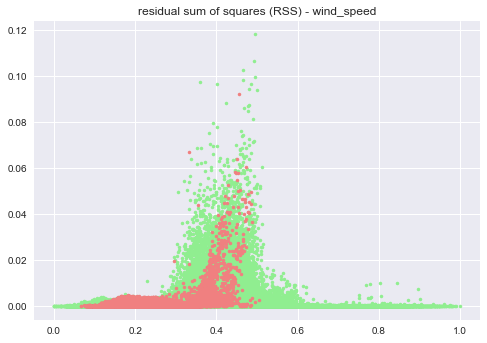

In [39]:
path='case_management/img/power/primary_allx/scatter/'
checkPath(path)

data_pass= dat_scaled_M15[dat_scaled_M15['label']==0]
data_fail= dat_scaled_M15[dat_scaled_M15['label']==1]

x='wind_speed'
y='power'

r, p = pearsonr(data_pass[x],data_pass[y])
raw_clr = 'lightgreen' if r>0.5 else 'darkgray'

model = xgb.XGBRegressor()
X = xcols

model = model.fit(data_pass[X],data_pass[y])
y_pred_p = model.predict(data_pass[X])
y_pred_f = model.predict(data_fail[X])
r2_p = sklearn.metrics.r2_score(data_pass[y],y_pred_p)
r2_f = sklearn.metrics.r2_score(data_fail[y],y_pred_f)
#pred_clr = 'firebrick' if r2_p > 0.8 else 'royalblue'

fig = plt.figure()
ax = fig.add_subplot(111)
data_visual = data_pass[[y, x]]
plt.plot(data_visual[x],data_visual[y],'.', color=raw_clr)

#data_visual = data_fail[[y, x]]
#plt.plot(data_visual[x],data_visual[y],'.', color='lightcoral')

plt.plot(data_pass[x],y_pred_p,'*', color='royalblue')
#plt.plot(data_fail[x],y_pred_f,'*', color='firebrick')

msg = 'r={corr:.3f}\np={pval:.3f}\nr2_score={r2:.3f}'.format(corr=r, pval=p,r2=r2_p)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
plt.text(xmin,ymax ,msg, verticalalignment='top')
plt.show()

rss_p = (data_pass[y] - y_pred_p)**2
rss_f = (data_fail[y] - y_pred_f)**2
plt.plot(data_pass[x],rss_p,'.', color='lightgreen')
plt.plot(data_fail[x],rss_f,'.', color='lightcoral')
plt.title('residual sum of squares (RSS) - {x}'.format(x=x))
imagename='{p}{n}.jpg'.format(p=path, n='all')
plt.savefig(imagename,bbox_inches='tight', dpi=200)
plt.show()

** 2. Predict Power by all X without generator_speed **

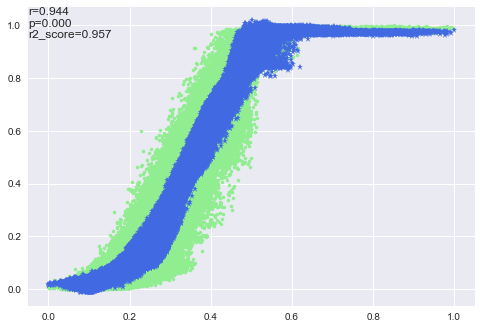

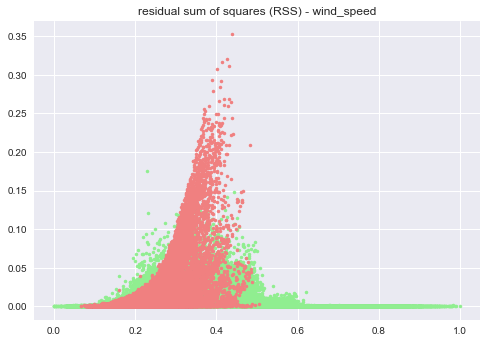

In [40]:
path='case_management/img/power/primary_allx/scatter/'
checkPath(path)

xcols2= xcols.copy()
xcols2.remove('generator_speed')


data_pass= dat_scaled_M15[dat_scaled_M15['label']==0]
data_fail= dat_scaled_M15[dat_scaled_M15['label']==1]

x='wind_speed'
y='power'

r, p = pearsonr(data_pass[x],data_pass[y])
raw_clr = 'lightgreen' if r>0.5 else 'darkgray'

model = xgb.XGBRegressor()
X = xcols2

model = model.fit(data_pass[X],data_pass[y])
y_pred_p = model.predict(data_pass[X])
y_pred_f = model.predict(data_fail[X])
r2_p = sklearn.metrics.r2_score(data_pass[y],y_pred_p)
r2_f = sklearn.metrics.r2_score(data_fail[y],y_pred_f)
#pred_clr = 'firebrick' if r2_p > 0.8 else 'royalblue'

fig = plt.figure()
ax = fig.add_subplot(111)
data_visual = data_pass[[y, x]]
plt.plot(data_visual[x],data_visual[y],'.', color=raw_clr)

#data_visual = data_fail[[y, x]]
#plt.plot(data_visual[x],data_visual[y],'.', color='lightcoral')

plt.plot(data_pass[x],y_pred_p,'*', color='royalblue')
#plt.plot(data_fail[x],y_pred_f,'*', color='firebrick')

msg = 'r={corr:.3f}\np={pval:.3f}\nr2_score={r2:.3f}'.format(corr=r, pval=p,r2=r2_p)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
plt.text(xmin,ymax ,msg, verticalalignment='top')
plt.show()

rss_p = (data_pass[y] - y_pred_p)**2
rss_f = (data_fail[y] - y_pred_f)**2
plt.plot(data_pass[x],rss_p,'.', color='lightgreen')
plt.plot(data_fail[x],rss_f,'.', color='lightcoral')
plt.title('residual sum of squares (RSS) - {x}'.format(x=x))
imagename='{p}{n}.jpg'.format(p=path, n='all2')
plt.savefig(imagename,bbox_inches='tight', dpi=200)
plt.show()

** 3. RSS vs. all other factors **

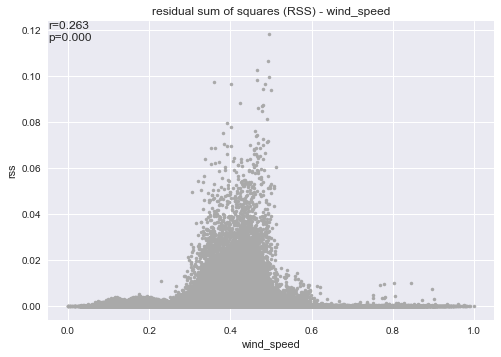

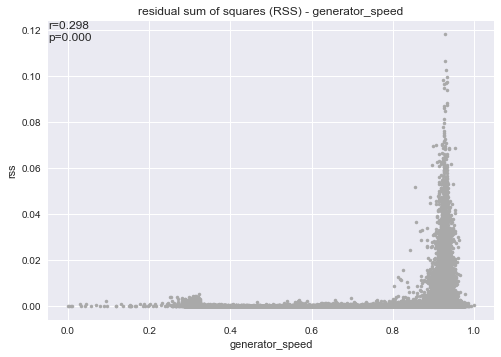

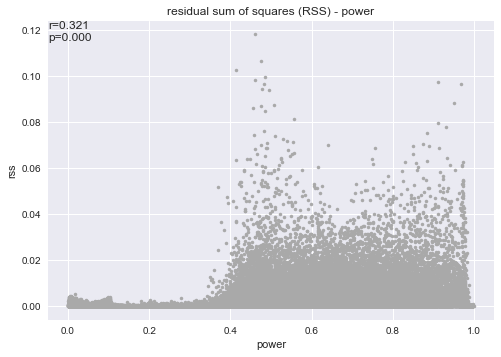

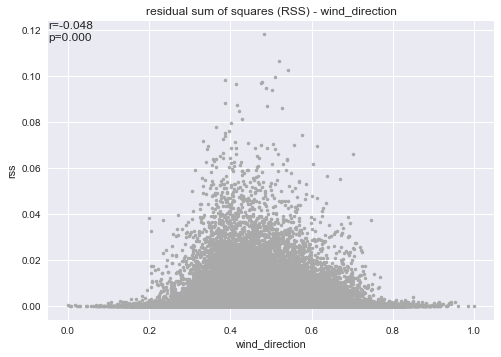

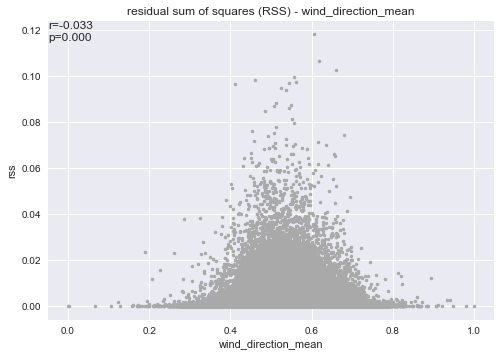

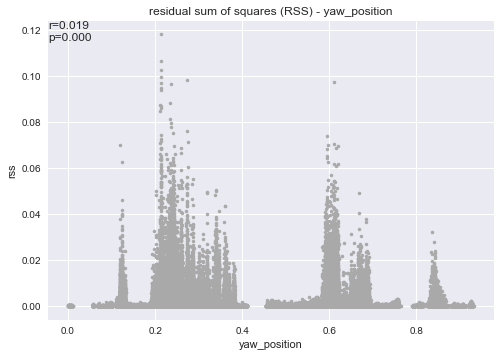

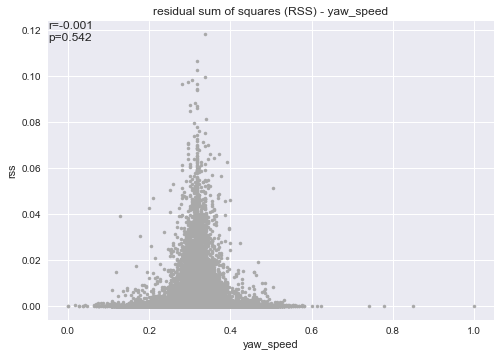

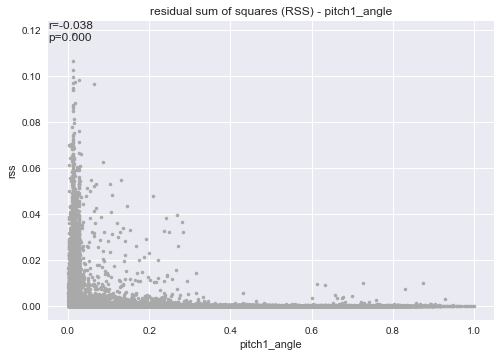

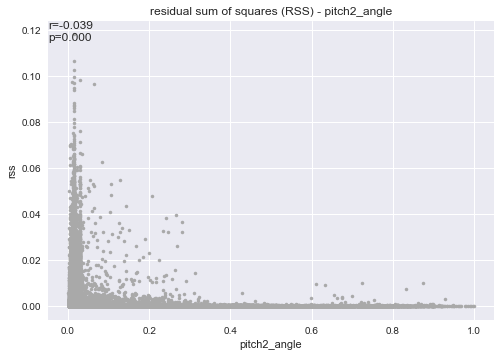

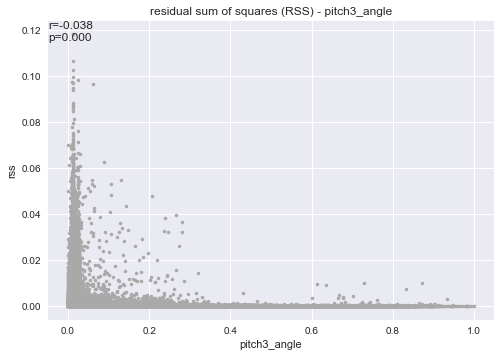

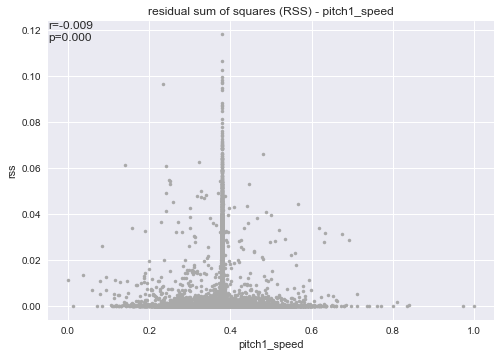

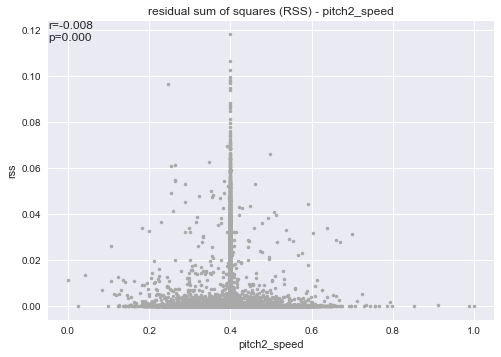

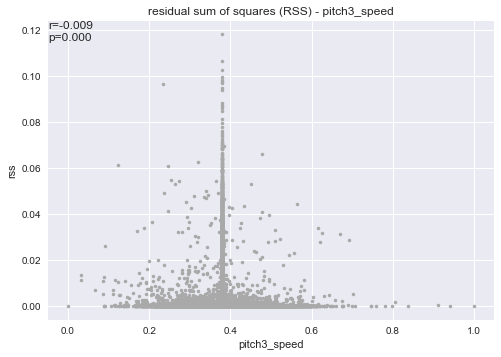

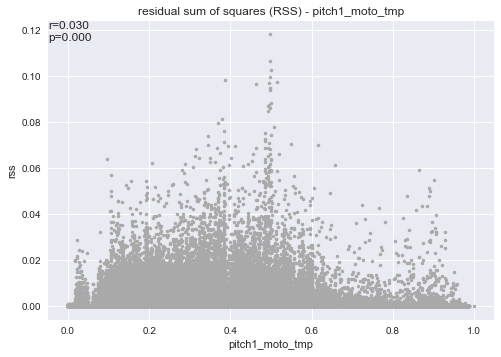

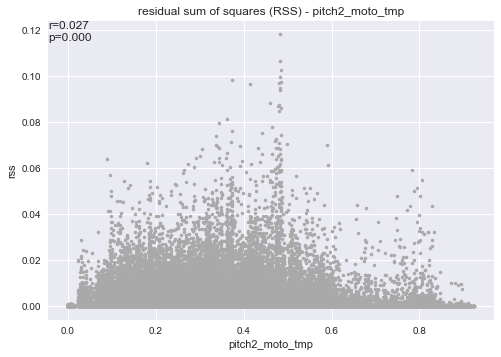

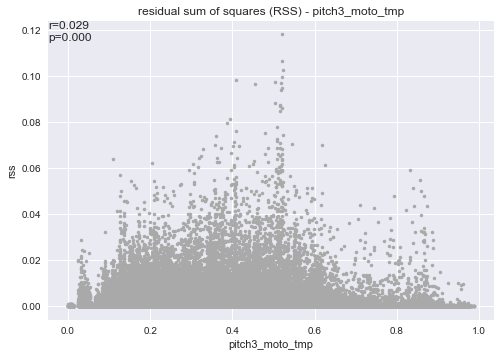

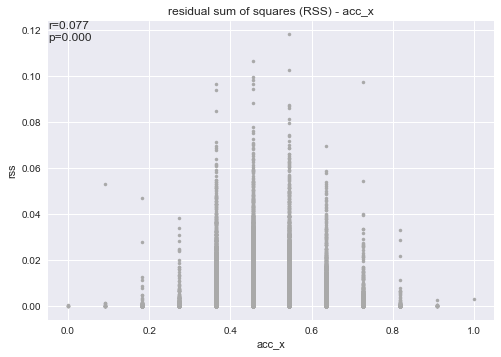

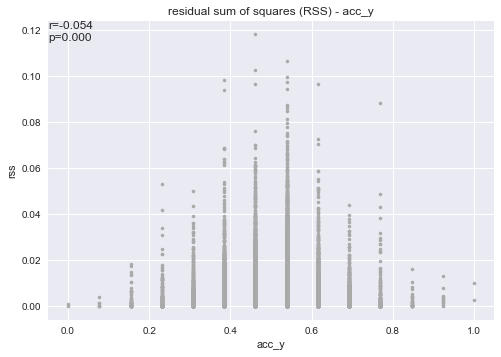

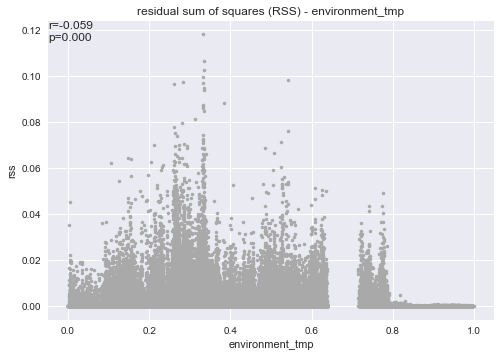

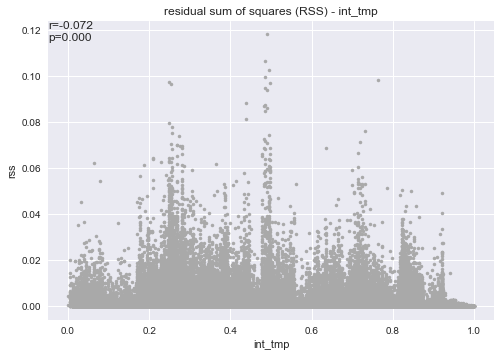

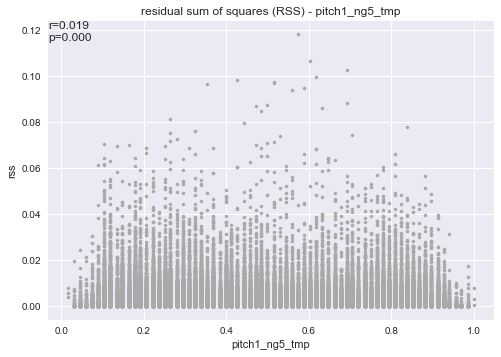

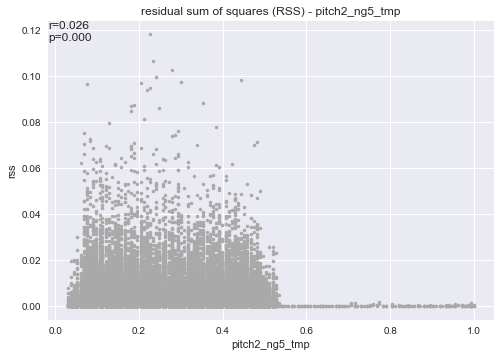

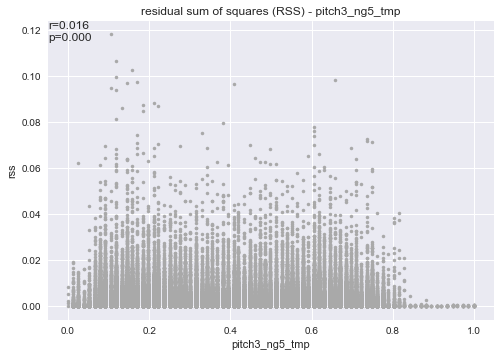

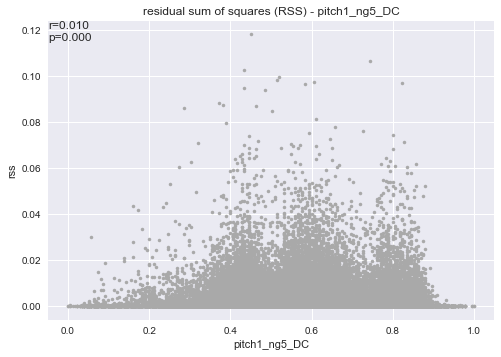

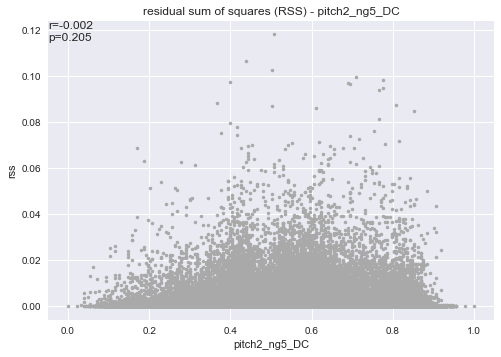

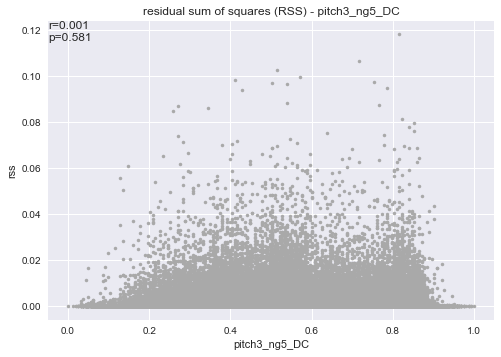

,corr,var
2,0.321284,power
1,0.298277,generator_speed
0,0.263053,wind_speed
16,0.077236,acc_x
13,0.030290,pitch1_moto_tmp
15,0.028833,pitch3_moto_tmp
14,0.026692,pitch2_moto_tmp
21,0.026122,pitch2_ng5_tmp
20,0.019077,pitch1_ng5_tmp
5,0.019027,yaw_position


In [19]:
path='case_management/img/power/primary_allx/RSS/'
checkPath(path)

cols = dat_scaled_M15.columns
non_data_cols = ['label','time','group','timestamp','event']
corr_lst = []
var_lst = []
for x in cols:
    if x in non_data_cols:
        continue
    fig = plt.figure()
    ax = fig.add_subplot(111)
    var_lst.append(x)
    plt.plot(data_pass[x],rss_p,'.', color=raw_clr)
    r, p = pearsonr(data_pass[x],rss_p)
    corr_lst.append(r)
    raw_clr = 'lightgreen' if r>0.5 else 'darkgray'
    msg = 'r={corr:.3f}\np={pval:.3f}'.format(corr=r, pval=p)
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    plt.text(xmin,ymax,msg,verticalalignment='top')
    #plt.plot(data_fail[x],rss_f,'.', color='lightcoral')
    plt.title('residual sum of squares (RSS) - {x}'.format(x=x))
    imagename='{p}{n}.jpg'.format(p=path, n=x)
    plt.xlabel(x)
    plt.ylabel('rss')
    plt.savefig(imagename,bbox_inches='tight', dpi=200)
    plt.show()

corr_df = pd.DataFrame({'var':var_lst,'corr':corr_lst})
corr_df.sort_values('corr',ascending=False)